# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

from scipy import stats

## Read in an Image

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/solidWhiteRight.jpg'

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [49]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, np.int32([vertices]), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def chk_and_get_slope_intercept(x1, y1, x2, y2):
    """
    Finds slope of all lines detected by hough transform to determine if a line is vertical or horizontal.
    
    Returns True if line is vertical and False if line is horizontal
    """

    lane_side = "invalid"
    slope = 0
    intercept = 0

    transformed_y1 = image.shape[0] - y1
    transformed_y2 = image.shape[0] - y2
    
    if(transformed_y1 > transformed_y2):
        top_x = x1
        top_y = transformed_y1
        bottom_x = x2
        bottom_y = transformed_y2
    else:
        top_x = x2
        top_y = transformed_y2
        bottom_x = x1
        bottom_y = transformed_y1
    
    if (top_x != bottom_x):
        slope = (top_y-bottom_y)/(top_x-bottom_x)
    
        
    if(abs(slope) > 0.5):

        if(bottom_x <= image.shape[1]/2):
            if(slope > 0):
                intercept = bottom_y - (slope * bottom_x)                
                lane_side = 'left'
        else:
            if(slope < 0):
                intercept = bottom_y - (slope * bottom_x)
                lane_side = 'right'

                
    return lane_side, slope, intercept

def remove_outliers(lines, slope_avg, intercept_avg):
    
    clines = []
    distance_from_mean = []
    
    for line in lines:
        dist = math.sqrt((line[1] - slope_avg)**2 + 
                         ((line[2] - intercept_avg)**2))
        distance_from_mean.append(dist)
        clines.append([line[0]])
    
    print('distance from mean', distance_from_mean)
    print('Avg distance from mean = ', sum(distance_from_mean)/len(distance_from_mean))

    """
    z = np.abs(stats.zscore(distance_from_mean))
    print('z = ', z)
    print(np.where(z > 1))
    print(np.array(clines)[np.where(z > 1)])
    """
    sorted_distance_from_mean_sum = 0
    sorted_distance_from_mean = np.sort(distance_from_mean)
    half_number_of_points = round(len(sorted_distance_from_mean)/2)
    for i in range(half_number_of_points):
        sorted_distance_from_mean_sum += sorted_distance_from_mean[i]
    sorted_distance_from_mean_avg = sorted_distance_from_mean_sum/half_number_of_points
    outer_limit_distance = sorted_distance_from_mean_avg * 3
    print("Avg of first half points = ", sorted_distance_from_mean_avg)
    print("Outer limit distance = ", outer_limit_distance)
    print(np.where(distance_from_mean > outer_limit_distance))
    print(np.array(clines)[np.where(distance_from_mean > outer_limit_distance)])
        
    return np.array(clines)[np.where(distance_from_mean < outer_limit_distance)]
    

def cleanup_lines(lines):
    """
    Do the following clean-up
    
    1. Remove horizontal lines
    2. Remove any outlier lines that are not part of the lane
    
    """
    valid_lines = []
    left_lane_lines = []
    right_lane_lines = []
    
    left_slope_sum = 0
    left_intercept_sum = 0
    left_slope_avg = 0
    left_intercept_avg = 0
    right_slope_sum = 0
    right_intercept_sum = 0
    right_slope_avg = 0
    right_intercept_avg = 0
    
    for line in lines:
#        print('original line type is:', type(line))
#        print('original line shape is:', line.shape)
#        print('original line = ', line)
        for x1,y1,x2,y2 in line:
            lane_side, slope, intercept = chk_and_get_slope_intercept(x1, y1, x2, y2)
            if lane_side != 'invalid':
                
                print(x1,y1,x2,y2)
                print('lane side = ', lane_side)
                print('slope = ', slope)
                print('intercept = ', intercept)
                
                if lane_side == 'left':
                    left_lane_lines.append(((x1, y1, x2, y2), slope, intercept))
                    left_slope_sum += slope
                    left_intercept_sum += intercept
#                    print("left slope sum = ", left_slope_sum)
#                    print("left intercept sum = ", left_intercept_sum)
                else:
                    right_lane_lines.append(((x1, y1, x2, y2), slope, intercept))
                    right_slope_sum += slope
                    right_intercept_sum += intercept
#                    print("right slope sum = ", right_slope_sum)
#                    print("right intercept sum = ", right_intercept_sum)
                    
    if len(left_lane_lines) > 0:
        left_slope_avg = left_slope_sum / len(left_lane_lines)
        left_intercept_avg = left_intercept_sum / len(left_lane_lines)
    if len(right_lane_lines) > 0:
        right_slope_avg = right_slope_sum / len(right_lane_lines)
        right_intercept_avg = right_intercept_sum / len(right_lane_lines)
        

#    print("No. of left lane line = ", len(left_lane_lines))
#    print("Accumulated left slope, intecept = ", left_slope_sum, " ", left_intercept_sum)
#    print("left avg slope and intercept = ", left_slope_avg, " ", left_intercept_avg)
    print("No. of right lane line = ", len(right_lane_lines))
#    print("Accumulated right slope, intecept = ", right_slope_sum, " ", right_intercept_sum)
    print("right avg slope and intercept = ", right_slope_avg, " ", right_intercept_avg)

    
    cleaned_left_lane_lines = remove_outliers(left_lane_lines, left_slope_avg, left_intercept_avg)
    cleaned_right_lane_lines = remove_outliers(right_lane_lines, right_slope_avg, right_intercept_avg)
#    print('left line type = ', cleaned_left_lane_lines.shape)
#    print('right line shape = ', cleaned_right_lane_lines.shape)
    valid_lines = np.concatenate((cleaned_left_lane_lines, cleaned_right_lane_lines))

    return valid_lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    valid_lines = cleanup_lines(lines)
    
    for line in valid_lines:
#        print('line type is:', type(line))
#        print('line shape is:', line.shape)
#        print('line = ', line)
        for x1,y1,x2,y2 in line:
            print(x1,y1,x2,y2)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

solidYellowCurve2.jpg
251 482 449 333
lane side =  left
slope =  0.752525252525
intercept =  -130.883838384
712 445 874 539
lane side =  right
slope =  -0.58024691358
intercept =  508.135802469
263 464 448 330
lane side =  left
slope =  0.724324324324
intercept =  -114.497297297
390 378 454 330
lane side =  left
slope =  0.75
intercept =  -130.5
160 538 404 361
lane side =  left
slope =  0.725409836066
intercept =  -114.06557377
701 448 851 538
lane side =  right
slope =  -0.6
intercept =  512.6
700 447 852 538
lane side =  right
slope =  -0.598684210526
intercept =  512.078947368
180 538 243 490
lane side =  left
slope =  0.761904761905
intercept =  -135.142857143
520 330 612 394
lane side =  right
slope =  -0.695652173913
intercept =  571.739130435
236 494 287 456
lane side =  left
slope =  0.745098039216
intercept =  -129.843137255
521 333 591 373
lane side =  right
slope =  -0.571428571429
intercept =  504.714285714
178 538 240 492
lane side =  left
slope =  0.741935483871
intercep

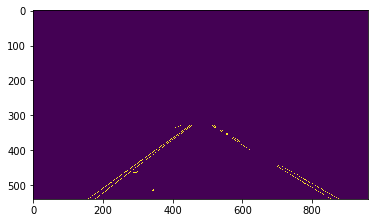

solidYellowLeft.jpg
138 538 386 370
lane side =  left
slope =  0.677419354839
intercept =  -91.4838709677
138 539 352 394
lane side =  left
slope =  0.677570093458
intercept =  -92.5046728972
158 539 264 462
lane side =  left
slope =  0.72641509434
intercept =  -113.773584906
199 510 437 337
lane side =  left
slope =  0.726890756303
intercept =  -114.651260504
661 425 754 485
lane side =  right
slope =  -0.645161290323
intercept =  541.451612903
672 424 783 493
lane side =  right
slope =  -0.621621621622
intercept =  533.72972973
524 330 578 366
lane side =  right
slope =  -0.666666666667
intercept =  559.333333333
518 330 606 387
lane side =  right
slope =  -0.647727272727
intercept =  545.522727273
370 380 444 330
lane side =  left
slope =  0.675675675676
intercept =  -90.0
661 424 768 493
lane side =  right
slope =  -0.644859813084
intercept =  542.252336449
696 438 784 493
lane side =  right
slope =  -0.625
intercept =  537.0
172 529 446 330
lane side =  left
slope =  0.72627737226

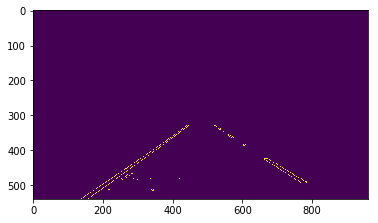

solidWhiteRight.jpg
520 330 854 538
lane side =  right
slope =  -0.622754491018
intercept =  533.832335329
514 330 784 506
lane side =  right
slope =  -0.651851851852
intercept =  545.051851852
633 408 831 537
lane side =  right
slope =  -0.651515151515
intercept =  544.409090909
521 331 853 539
lane side =  right
slope =  -0.626506024096
intercept =  535.409638554
515 330 650 418
lane side =  right
slope =  -0.651851851852
intercept =  545.703703704
320 417 445 330
lane side =  left
slope =  0.696
intercept =  -99.72
318 425 449 330
lane side =  left
slope =  0.725190839695
intercept =  -115.610687023
712 486 777 537
lane side =  right
slope =  -0.784615384615
intercept =  612.646153846
321 424 449 331
lane side =  left
slope =  0.7265625
intercept =  -117.2265625
390 369 446 331
lane side =  left
slope =  0.678571428571
intercept =  -93.6428571429
777 503 832 538
lane side =  right
slope =  -0.636363636364
intercept =  531.454545455
711 484 778 537
lane side =  right
slope =  -0.7910

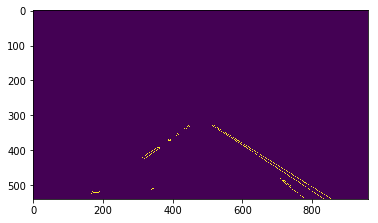

solidYellowCurve.jpg
154 538 451 330
lane side =  left
slope =  0.700336700337
intercept =  -105.851851852
175 539 448 333
lane side =  left
slope =  0.754578754579
intercept =  -131.051282051
304 443 437 343
lane side =  left
slope =  0.751879699248
intercept =  -131.571428571
172 525 302 434
lane side =  left
slope =  0.7
intercept =  -105.4
174 538 272 465
lane side =  left
slope =  0.744897959184
intercept =  -127.612244898
511 330 652 414
lane side =  right
slope =  -0.595744680851
intercept =  514.425531915
155 538 218 494
lane side =  left
slope =  0.698412698413
intercept =  -106.253968254
505 330 607 391
lane side =  right
slope =  -0.598039215686
intercept =  512.009803922
258 466 388 375
lane side =  left
slope =  0.7
intercept =  -106.6
576 374 651 419
lane side =  right
slope =  -0.6
intercept =  511.6
512 332 577 374
lane side =  right
slope =  -0.646153846154
intercept =  538.830769231
No. of right lane line =  4
right avg slope and intercept =  -0.609984435673   519.216

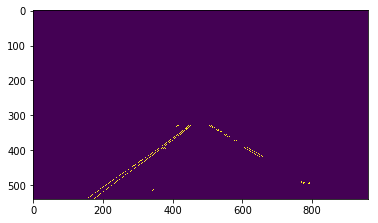

whiteCarLaneSwitch.jpg
195 539 462 330
lane side =  left
slope =  0.782771535581
intercept =  -151.640449438
309 438 455 331
lane side =  left
slope =  0.732876712329
intercept =  -124.45890411
724 450 883 538
lane side =  right
slope =  -0.553459119497
intercept =  490.704402516
743 466 863 538
lane side =  right
slope =  -0.6
intercept =  519.8
175 538 274 466
lane side =  left
slope =  0.727272727273
intercept =  -125.272727273
743 467 863 539
lane side =  right
slope =  -0.6
intercept =  518.8
695 432 883 537
lane side =  right
slope =  -0.558510638298
intercept =  496.164893617
268 469 446 339
lane side =  left
slope =  0.730337078652
intercept =  -124.730337079
266 482 421 361
lane side =  left
slope =  0.78064516129
intercept =  -149.651612903
512 330 605 383
lane side =  right
slope =  -0.569892473118
intercept =  501.784946237
518 330 607 380
lane side =  right
slope =  -0.561797752809
intercept =  501.011235955
696 432 771 474
lane side =  right
slope =  -0.56
intercept =  49

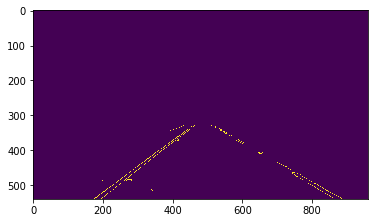

solidWhiteCurve.jpg
517 331 877 538
lane side =  right
slope =  -0.575
intercept =  506.275
525 332 898 538
lane side =  right
slope =  -0.552278820375
intercept =  497.946380697
293 462 353 410
lane side =  left
slope =  0.866666666667
intercept =  -175.933333333
280 460 347 410
lane side =  left
slope =  0.746268656716
intercept =  -128.955223881
383 381 443 336
lane side =  left
slope =  0.75
intercept =  -128.25
690 447 765 496
lane side =  right
slope =  -0.653333333333
intercept =  543.8
385 382 457 330
lane side =  left
slope =  0.722222222222
intercept =  -120.055555556
536 341 834 513
lane side =  right
slope =  -0.577181208054
intercept =  508.369127517
300 457 353 412
lane side =  left
slope =  0.849056603774
intercept =  -171.716981132
691 447 776 500
lane side =  right
slope =  -0.623529411765
intercept =  523.858823529
391 382 450 331
lane side =  left
slope =  0.864406779661
intercept =  -179.983050847
389 382 458 330
lane side =  left
slope =  0.753623188406
intercept =

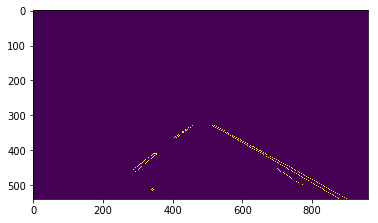

In [50]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

canny_low_threshold = 20
canny_high_threshold = 80

blur_kernel_size = 5

hough_rho = 1
hough_theta = np.pi/180
hough_threshold = 20
hough_min_line_length = 50                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
hough_max_line_gap = 30
    
roi_left_top = [410, 330]
roi_right_top = [550, 330]
roi_right_bottom = [940, 539]
roi_left_bottom = [130, 539]

vertices = np.array([roi_left_bottom,roi_left_top,roi_right_top,roi_right_bottom], np.int32)

for image_file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/"+image_file)
    print(image_file)
    gray_image = grayscale(image)
    gray_blur_image = gaussian_blur(gray_image,blur_kernel_size)
    canny_image = canny(gray_blur_image, canny_low_threshold, canny_high_threshold)
    roi_image = region_of_interest(canny_image, vertices)
    line_image = hough_lines(roi_image, hough_rho, hough_theta, hough_threshold,
                        hough_min_line_length, hough_max_line_gap)
#    roi_image = region_of_interest(line_image, vertices)
    marked_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    
    mpimg.imsave('test_images_output/'+image_file, marked_image,format='jpeg')
    plt.imshow(roi_image)
    plt.show()    
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))